In [15]:
import pandas as pd
import numpy as np
import tomllib
import copy
import json


class Diseas_work:
    """
    Класс для анализа и оценки вероятности наличия заболеваний на основе параметров,
    заданных в TOML-файле. Поддерживает динамическую загрузку критериев заболевания,
    нормализацию данных, сравнение с допустимыми диапазонами и расчёт вероятности
    на основе евклидова расстояния в нормализованном пространстве параметров.
    """
    def __init__(self, file=None, coef=0):
        """
        Инициализирует экземпляр класса.

        Параметры:
        ----------
        file : str или None, по умолчанию None
            Путь к TOML-файлу с описанием заболеваний и их параметров.
        coef : float, по умолчанию 0
            Коэффициент расширения диапазонов параметров (в процентах от исходного диапазона).
        """
        self.names = []
        self.prob_last={}
        self.diseas = {}
        self.diseas_check={}
        self.time = {}
        self.valid = {}
        self.prob = {}
        self.sens={}
        self.prob_sens={}
        if file!=None:
            self._add_diseas_toml(file, coef)

    def _add_diseas_toml(self, file, coef=0):
        """
        Загружает данные о заболеваниях из TOML-файла и инициализирует внутренние структуры.

        Параметры:
        ----------
        file : str
            Путь к TOML-файлу.
        coef : float
            Процентное расширение границ min/max для каждого параметра.
        """
        with open(file, "rb") as f:
            diseases = tomllib.load(f)
        for d_name in diseases:
            self.names.append(d_name)
            self.diseas[d_name] = pd.DataFrame(columns=("min", "max"))
            # print(d_name)
            for param in diseases[d_name]["param"]:
                if param == "time":
                    self.time[d_name] = diseases[d_name]["param"]["time"]["min"]
                else:
                    param_data = diseases[d_name]["param"][param]
                    min_val = param_data.get("min", 1e-6)
                    max_val = param_data.get("max", 1e6)
                    delta = (max_val - min_val) / 100 * coef
                    self.diseas[d_name].loc[param] = [min_val - delta, max_val + delta]
                    

    def _calc_prob(self,data, param_val, time):
        """
        Рассчитывает вероятность наличия заболевания на основе нормализованных данных
        и евклидова расстояния до «идеальной» точки (максимально соответствующей критериям).

        Параметры:
        ----------
        data : pandas.DataFrame
            Данные пациента с флагом 'check', указывающим на попадание в допустимый диапазон.
        param_val : pandas.DataFrame
            Границы (min, max) для каждого параметра заболевания.
        time : float
            Максимальная продолжительность (в часах), используемая как нормирующий масштаб.

        Возвращает:
        ----------
        pandas.Series
            Серия с вероятностями (в процентах) для каждой записи в data.
        """
        data=data[data['check']==True]
        param_val.loc['time']=[0,time*3600]
        # Нормализуем каждый параметр в диапазон [0, 1]
        df_norm = pd.DataFrame()
        for index, (low, high) in param_val.T.items():
            if index=='time':
                df_norm[index] =data[index] 
            else:
                df_norm[index] = (data[index] - low) / (high - low)
        data_mas = df_norm.to_numpy()
        # Опорная точка "идеального" состояния: все параметры = 0, кроме времени = time*3600
        m_v = [*[0]*len(param_val)]
        a_v = [*[0]*(len(param_val)-1), time*3600]
        b = np.array([a_v] * len(data_mas))
        # Вычисляем евклидово расстояние от каждой точки до целевой точки a_v
        l = np.linalg.norm(data_mas - b, axis=1)
        # Максимально возможное расстояние: от m_v до a_v
        ml = np.linalg.norm(np.array(m_v) - np.array(a_v))
        # Нормированная вероятность: 1 - (текущее расстояние / максимальное)
        # Преобразуем в проценты и упаковываем в Series с исходными индексами
        prob = 1 - l / ml
        prob= pd.Series( prob*100,index=data.index,name='prob')
        # Обнуляем крайне малые вероятности
        prob[prob<0.01]=0
        # Коррекция для длительных эпизодов: если время >= 1 интервал (time*3600),
        # вероятность растёт линейно: 100% + (n - 1)*100% - (остаток от исходной вероятности)
        for i in prob.index:
            c=data.loc[i,'time'] //(time*3600)
            if c>=1:
                prob[i]=100+c*100-prob[i]
        return prob

    def _compair_values(self, data, diseas_name):
        """
        Сравнивает входные данные с диапазонами параметров для указанного заболевания,
        определяет валидные интервалы и рассчитывает вероятность.

        Параметры:
        ----------
        data : pandas.DataFrame
            Входные данные с колонкой 'datetime'.
        diseas_name : str
            Название заболевания из загруженного TOML-файла.

        Возвращает:
        ----------
        pandas.DataFrame
            Расширенный DataFrame с колонками 'check', 'time', 'prob' и др.
        """
        df_range = copy.copy(self.diseas[diseas_name])
        time_sec=self.time[diseas_name] * 3600
        df_values = copy.copy(data)
        common_params = df_values.columns.intersection(df_range.index)
        df_values = df_values[common_params]
        df_range = df_range.reindex(common_params)
        valid = (df_values >= df_range["min"]) & (df_values <= df_range["max"])
        valid.columns = valid.columns + "_c"
        valid["check"] = valid.all(axis=1)
        valid["datetime"] = data["datetime"]
        
        if valid["check"].any()==True:
            valid["time_delta"] = valid["datetime"].diff().dt.total_seconds()
            mask = valid["check"]
            groups = (~mask).cumsum()
            valid["time"] = valid.loc[mask, "time_delta"].groupby(groups[mask]).cumsum()
            valid["time"] = valid["time"].fillna(0)
            valid.loc[valid["time"] > time_sec, "time"] = time_sec/2
            valid = pd.concat([valid, df_values], axis=1)

            prob=self._calc_prob(valid,df_range,self.time[diseas_name])
            valid=pd.concat([valid,prob], axis=1)
            valid["prob"] = valid["prob"].fillna(0)
        else:
            valid['prob']=0
        return valid

    def check_all_disease_for_one_sens(self, data:pd.DataFrame, time="last_hour"):
        """
        Анализирует данные за указанный временной интервал и обновляет внутренние
        атрибуты класса: вероятности, флаги наличия заболевания и временные ряды.

        Параметры:
        ----------
        data : pandas.DataFrame
            Входные данные с обязательной колонкой 'datetime'.
        time : str или int, по умолчанию "last_hour"
            Временной интервал анализа:
            - "last_hour": последний час;
            - "all": все данные;
            - int: последние N часов.
        """
        if time == "last_hour":
            time_last = data["datetime"].max()- pd.Timedelta(hours=1)
        elif time == "all":
            time_last = data["datetime"].min()
        else:
            time_last = data["datetime"].max() - pd.Timedelta(hours=time)
        data_last = data[data["datetime"] >= time_last]
        for d_name in self.names:
            # print("check ", d_name)
            # print(self.diseas[d_name])
            self.valid[d_name] = self._compair_values(data_last, d_name)
            
            self.prob_last[d_name]=self.valid[d_name]['prob'].iloc[-1]
            self.diseas_check[d_name]=self.valid[d_name]['prob'].any()
            self.prob[d_name]=self.valid[d_name].loc[:,['datetime','prob']]
            # print(' ',self.current[d_name])

    def check_one_disease_for_all_sens(self, data:pd.DataFrame, disease='',id_sens=[], time="last_hour"):
        """
        Анализирует данные за указанный временной интервал и обновляет внутренние
        атрибуты класса: вероятности, флаги наличия заболевания и временные ряды.

        Параметры:
        ----------
        data : pandas.DataFrame
            Входные данные с обязательной колонкой 'datetime'.
        time : str или int, по умолчанию "last_hour"
            Временной интервал анализа:
            - "last_hour": последний час;
            - "all": все данные;
            - int: последние N часов.
        """
        if time == "last_hour":
            time_last = data["datetime"].max()- pd.Timedelta(hours=1)
        elif time == "all":
            time_last = data["datetime"].min()
        else:
            time_last = data["datetime"].max() - pd.Timedelta(hours=time)
        data_last = data[data["datetime"] >= time_last]
        if len(id_sens)==0:
            id_sens=data['sensor_id'].unique()
        if disease=='':
            disease=self.names[0]
        self.sens=id_sens
        for sens in self.sens:
            # print("check ", disease,sens)
            sdata=data_last[data_last['sensor_id']==sens]
            self.valid[sens] = self._compair_values(sdata, disease)
            self.prob[sens]=self.valid[sens].loc[:,['datetime','prob']]


            self.prob_last[sens]=self.valid[sens]['prob'].iloc[-1]
            self.diseas_check[sens]=self.valid[sens]['prob'].any()
            # self.prob[d_name]=self.valid[d_name].loc[:,['datetime','prob']]
            # print(' ',self.current[d_name])

In [21]:
d = Diseas_work("deseas_grape.toml", 5)
data= pd.read_feather("meteo.feather")
data=data.rename(columns={'id_s':'sensor_id'})
d.check_one_disease_for_all_sens(data,d.names[6],time='all')

check  Drought 5
check  Drought 7
check  Drought 10


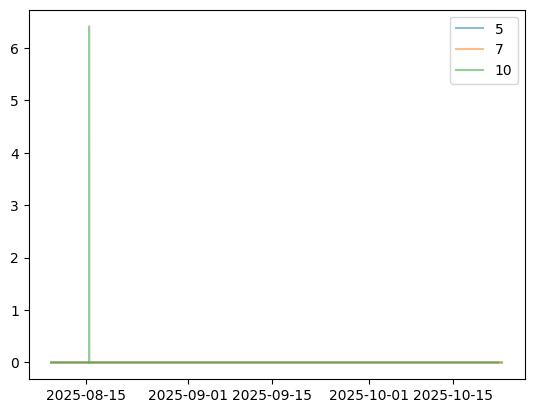

In [22]:
import matplotlib.pyplot as plt
for ids in data['sensor_id'].unique():
    plt.plot(d.prob[ids]['datetime'],d.prob[ids]['prob'],label=ids,alpha=0.5)
plt.legend()